<a href="https://colab.research.google.com/github/mknomics/tradewars/blob/LSTM/Toy_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tensorflow import keras
import os 
import zipfile
#import sklearn

#imports
'''
from tensorflow import keras
from tensorflow.keras.models import Sequential
#from keras import optimizers
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM
from tensorflow.keras import metrics

'''

from sklearn.preprocessing import MinMaxScaler


url = 'https://raw.githubusercontent.com/mknomics/tradewars/master/final1268.csv'

df = pd.read_csv(url)
df.head()
#first row has N/A values - drop this row
print(df.isna().sum())
df = df.drop(index=0)

period = df['period']
df = df.drop(columns=['x', 'T', 'r2', 's', 'sf', '_merge','period','HS7','pid','month', '_Imonth_2', '_Imonth_3', '_Imonth_4', '_Imonth_5', '_Imonth_6', '_Imonth_7', '_Imonth_8', '_Imonth_9', '_Imonth_10', '_Imonth_11', '_Imonth_12'])





#slice X and Y sets
X = df.iloc[:,1:].values
Y = df.iloc[:,0].values
Y = np.reshape(Y, (Y.shape[0],1))

#scale X and Y
X_scaler = MinMaxScaler(feature_range=(0,1))
Y_scaler = MinMaxScaler(feature_range=(0,1))


scaled_X = pd.DataFrame(X_scaler.fit_transform(X))
scaled_Y = pd.DataFrame(Y_scaler.fit_transform(Y))




period    0
HS7       0
T         0
pid       0
y         0
         ..
_merge    0
x         1
r2        0
s         1
sf        1
Length: 117, dtype: int64


# Logic of the slice
Tariff is announced at df.iloc[91:,:].  I originally sliced the pre-announcement period into a training and validation set (as seen below).  But these are not the same shape, which is a problem for LSTM models.  

I then moved away from this slicing scheme and moved towards creating windows in the dataset using TimeSeriesGenerator().  For now, I am using the set, X_fit, Y_fit, which includes all of the pre-treatment data.  But I am aware that there are parameters within TimeSeriesGenerator(), that might allow me to use the full dataset scaled_X , scaled_Y

In [52]:
'''
We will use a rolling window of size=timesteps.  This is used to dynamically split 
data so that the validation set is of size=timesteps.  "timesteps" is then used
in the data generator below

I pick a window = 12 because there are 12 months in a year
'''
timesteps = 12 

#define pre-treatment period
X_pre = scaled_X.iloc[:90,:].values
Y_pre = scaled_Y.iloc[:90,:].values

#define training sets
X_train = X_pre[0:-timesteps,:]
Y_train = Y_pre[0:-timesteps,:]

#define validation sets
X_validate = X_pre[-timesteps:,:]
Y_validate = Y_pre[-timesteps:,:]

#define test set, note that test set cannot be used with a data generator and a window = 12
#X_test_scaled = X_train.iloc[91:99,:]
#Y_test_scaled = Y_train.iloc[:,0]

'''
After hyperparameter optimization, I want to then fit the model on both sets
'''
#Fit set = train + validate
Y_fit = np.concatenate((Y_train, Y_validate), axis=0)
X_fit = np.concatenate((X_train, X_validate), axis=0)


'''
# Reshape X and Y to be 3D compatible with LSTM
X_train = X_train.reshape(1,X_train.shape[0], X_train.shape[1])
Y_train = Y_train.reshape(1,Y_train.shape[0], Y_train.shape[1])

X_validate = X_validate.reshape(1,X_validate.shape[0], X_validate.shape[1])
Y_validate = Y_validate.reshape(1,Y_validate.shape[0], Y_validate.shape[1])

X_fit = X_fit.reshape(1,X_fit.shape[0], X_fit.shape[1])
Y_fit = Y_fit.reshape(1,Y_fit.shape[0], Y_fit.shape[1])

X = X.reshape(1,X.shape[0], X.shape[1])
Y = Y.reshape(1,Y.shape[0], Y.shape[1])
'''
print("X_train shape", X_train.shape, "X_validate shape:", X_validate.shape, "X_fit shape:", X_fit.shape, "X shape:", X.shape)
print("Y_train shape", Y_train.shape, "Y_validate shape:", Y_validate.shape, "Y_fit shape", Y_fit.shape, "Y shape", Y.shape)

X_train shape (78, 95) X_validate shape: (12, 95) X_fit shape: (90, 95) X shape: (107, 95)
Y_train shape (78, 1) Y_validate shape: (12, 1) Y_fit shape (90, 1) Y shape (107, 1)


# Using TimeSeriesGenerator to create windows

In [0]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import CuDNNLSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import metrics
from keras.optimizers import SGD

#from tensorflow.keras import metrics
#from tensorflow.keras.optimizers import SGD
#from tensorflow.python.keras.utils.data_utils import Sequence

# load data
data = X_fit
targets = Y_fit

# define generator
# timesteps are defined above in "data split" section, in order to dynamically split the data to size 
n_features = X_fit.shape[1]

#Create training and validtion generators
train_generator = TimeseriesGenerator(data=X_train, targets=Y_train, length=timesteps, batch_size=timesteps)
validation_generator = TimeseriesGenerator(data=X_validate, targets=Y_validate, length=7, batch_size=timesteps)

#after model selection then fit on training + validation data
fit_generator = TimeseriesGenerator(data=X_fit, targets=Y_fit, length=timesteps, batch_size=timesteps)

#prediction model for post treatment
full_generator = TimeseriesGenerator(data=X, targets=Y, length=timesteps, batch_size=timesteps)


In [77]:
print(X_fit.shape, Y_fit.shape)

(90, 95) (90, 1)


# Documentation on TimeSeriesGenerator: 
data: Indexable generator (such as list or Numpy array) containing consecutive data points (timesteps). The data should be at 2D, and axis 0 is expected to be the time dimension.

targets: Targets corresponding to timesteps in data. It should have same length as data.

length: Length of the output sequences (in number of timesteps).

sampling_rate: Period between successive individual timesteps within sequences. For rate r, timesteps data[i], data[i-r], ... data[i - length] are used for create a sample sequence.

stride: Period between successive output sequences. For stride s, consecutive output samples would be centered around data[i], data[i+s], data[i+2*s], etc.

start_index: Data points earlier than start_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.

end_index: Data points later than end_index will not be used in the output sequences. This is useful to reserve part of the data for test or validation.

shuffle: Whether to shuffle output samples, or instead draw them in chronological order.

reverse: Boolean: if true, timesteps in each output sample will be in reverse chronological order.

batch_size: Number of timeseries samples in each batch (except maybe the last one).


# The Simple Model 
model.fit is now using model.fit_generator method 

Step 1 is to get a simple model up and running, then optimize design


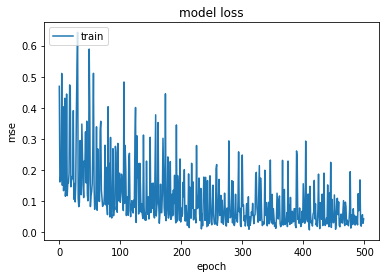

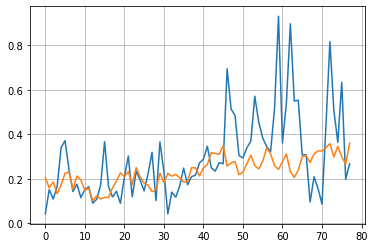

In [83]:
#make model
model = Sequential()
'''
NOTE: TimeseriesGenerator creates a set with length timesteps
'''
model.add(LSTM(50, input_shape=(timesteps, n_features), activation="relu", return_sequences=True)) 
#model.add(LSTM(50, batch_input_shape=(timesteps, n_features), activation="relu", return_sequences=True, stateful=True))  
model.add(Dropout(0.3))
'''
NOTE: Adding Flatten solves dimensionality problem but need to better understand implications of Flatten layer
LSTM is a 3 dim object but then Dens layers take 2D is my current understanding.  Still not 100 percent sure.
'''
model.add(Flatten())
'''
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.3))
'''

model.add(Dense(1)) 

optimizer = SGD(lr=0.0001, momentum=0.001, decay=0.001, nesterov=False)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_squared_error'])
# fit model
train_history = model.fit_generator(train_generator, steps_per_epoch=1, epochs=500, verbose=0)  
#model.fit(X_train, Y_train , validation_data=(X_validate, Y_validate), epochs=2 , verbose=1) # This model crapped out because training and validation are not same shape

#Evaluate the model

# summarize history for loss
plt.plot(train_history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#model.predict(X_validate)
#print(history.history.keys())
yhat_val = model.predict_generator(generator=fit_generator)

#plot predictions vs actual

dt = 1
t = np.arange(0, yhat_val.shape[0], dt)

plt.plot(t, Y_fit[timesteps:, :], t, yhat_val)

plt.grid(True)

plt.show()